### 1. Data Understanding and Exploration

Let's first have a look at the dataset and understand the size, attribute names etc.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score
from sklearn.utils import resample
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In [2]:
# reading the dataset
train_df = pd.read_csv("../input/housing-price/train.csv")

In [3]:
train_df.drop('Id', axis=1, inplace=True)

Drop the columns with more than 80% missing values

In [4]:
missing_val_per = train_df.isnull().sum()/len(train_df)
train_df = train_df.drop(missing_val_per.index[missing_val_per>=.8],axis=1)

Replaacing NA value as per given data from data dictonary

In [5]:
train_df['BsmtQual'] = train_df['BsmtQual'].fillna('No Basement')
train_df['BsmtCond'] = train_df['BsmtCond'].fillna('No Basement')
train_df['BsmtExposure'] = train_df['BsmtExposure'].fillna('No Basement')
train_df['BsmtFinType1'] = train_df['BsmtFinType1'].fillna('No Basement')
train_df['BsmtFinType2'] = train_df['BsmtFinType2'].fillna('No Basement')
train_df['FireplaceQu'] = train_df['FireplaceQu'].fillna('No FirePlace')
train_df['GarageType'] = train_df['GarageType'].fillna('No Garage')
train_df['GarageFinish'] = train_df['GarageFinish'].fillna('No Garage')
train_df['GarageQual'] = train_df['GarageQual'].fillna('No Garage')
train_df['GarageCond'] = train_df['GarageCond'].fillna('No Garage')

Correcting columns types and values

In [6]:
train_df['MSSubClass'] = train_df['MSSubClass'].astype(str)

In [7]:
train_df['Exterior2nd'] = train_df['Exterior2nd'].apply(lambda x: 'WdShing' if x=='Wd Shng' else x)
train_df['Exterior2nd'] = train_df['Exterior2nd'].apply(lambda x: 'BrkComm' if x=='Brk Cmn' else x)
train_df['Exterior2nd'] = train_df['Exterior2nd'].apply(lambda x: 'CemntBd' if x=='CmentBd' else x)

Dropping categorical columns which have more than 80% class imbalance

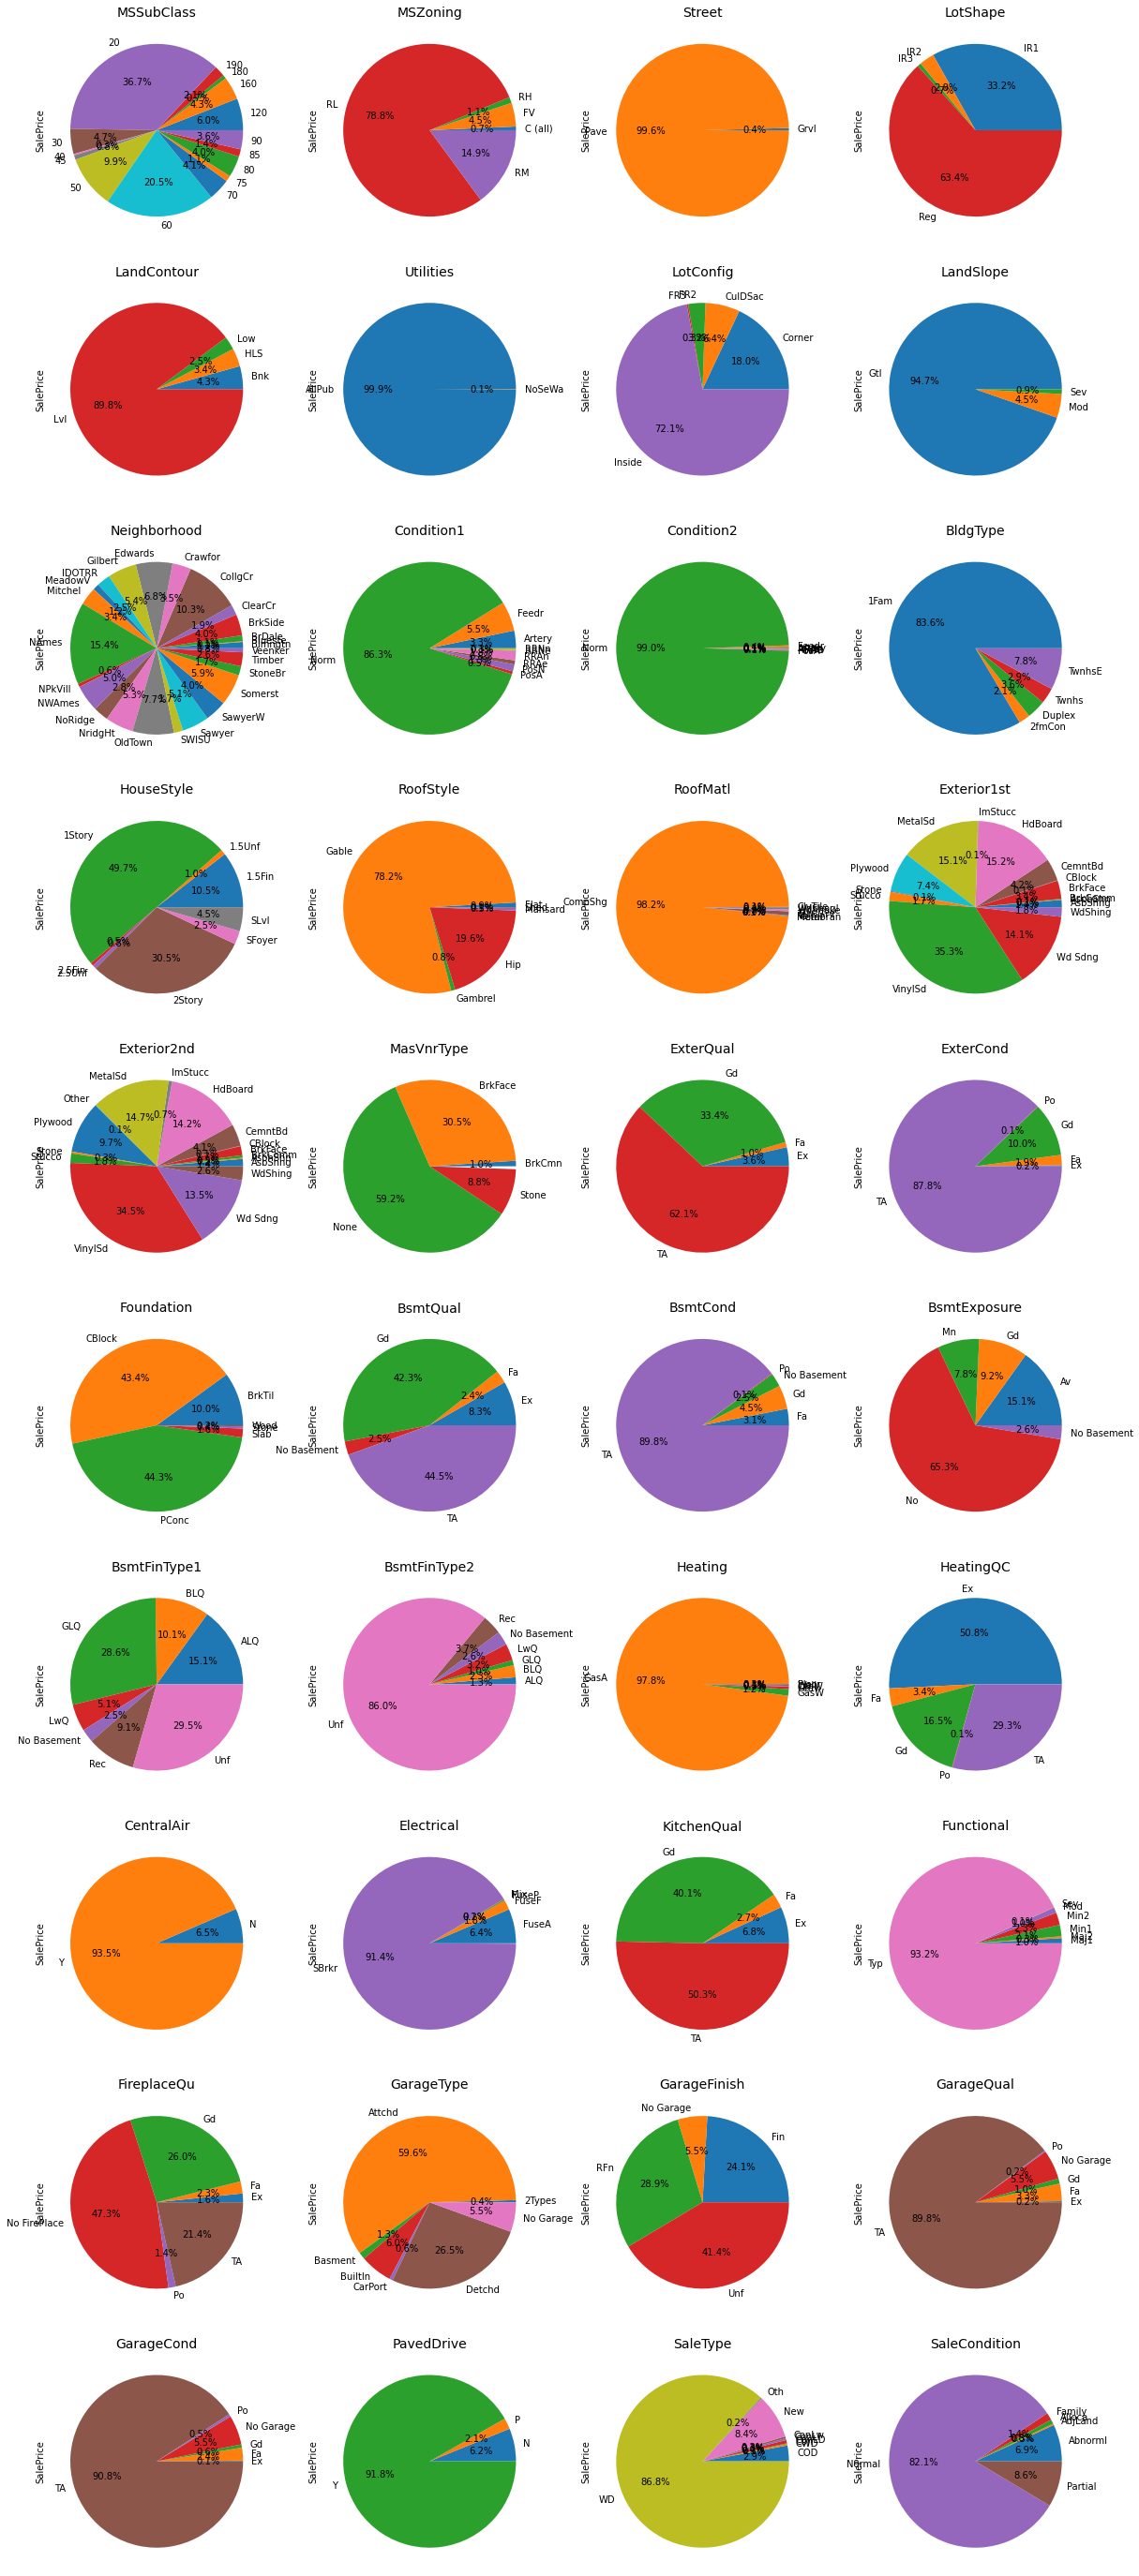

In [8]:
cat_var = train_df.select_dtypes(include='object')
plt.figure(figsize=(20,50))
i=0
for col in cat_var.columns:
    i+=1
    plt.subplot(10,4,i)
    data = train_df.groupby(col)['SalePrice'].count()/len(train_df[col])
    plt.title(col, fontsize=14)
#     sns.barplot(x=col, y='SalePrice', data=train_df, estimator=lambda x: len(x) / len(train_df) * 100)
    data.plot.pie(autopct="%.1f%%",subplots=True)
plt.show()

In [9]:
train_df.drop(['Street','Utilities','LandContour','LandSlope','Condition1','Condition2','BldgType','RoofMatl','ExterCond','Heating','BsmtCond','BsmtFinType2','CentralAir','Electrical','Functional','GarageQual','GarageCond','PavedDrive','SaleType','SaleCondition'],axis=1,inplace=True)

Visualising numerical columns

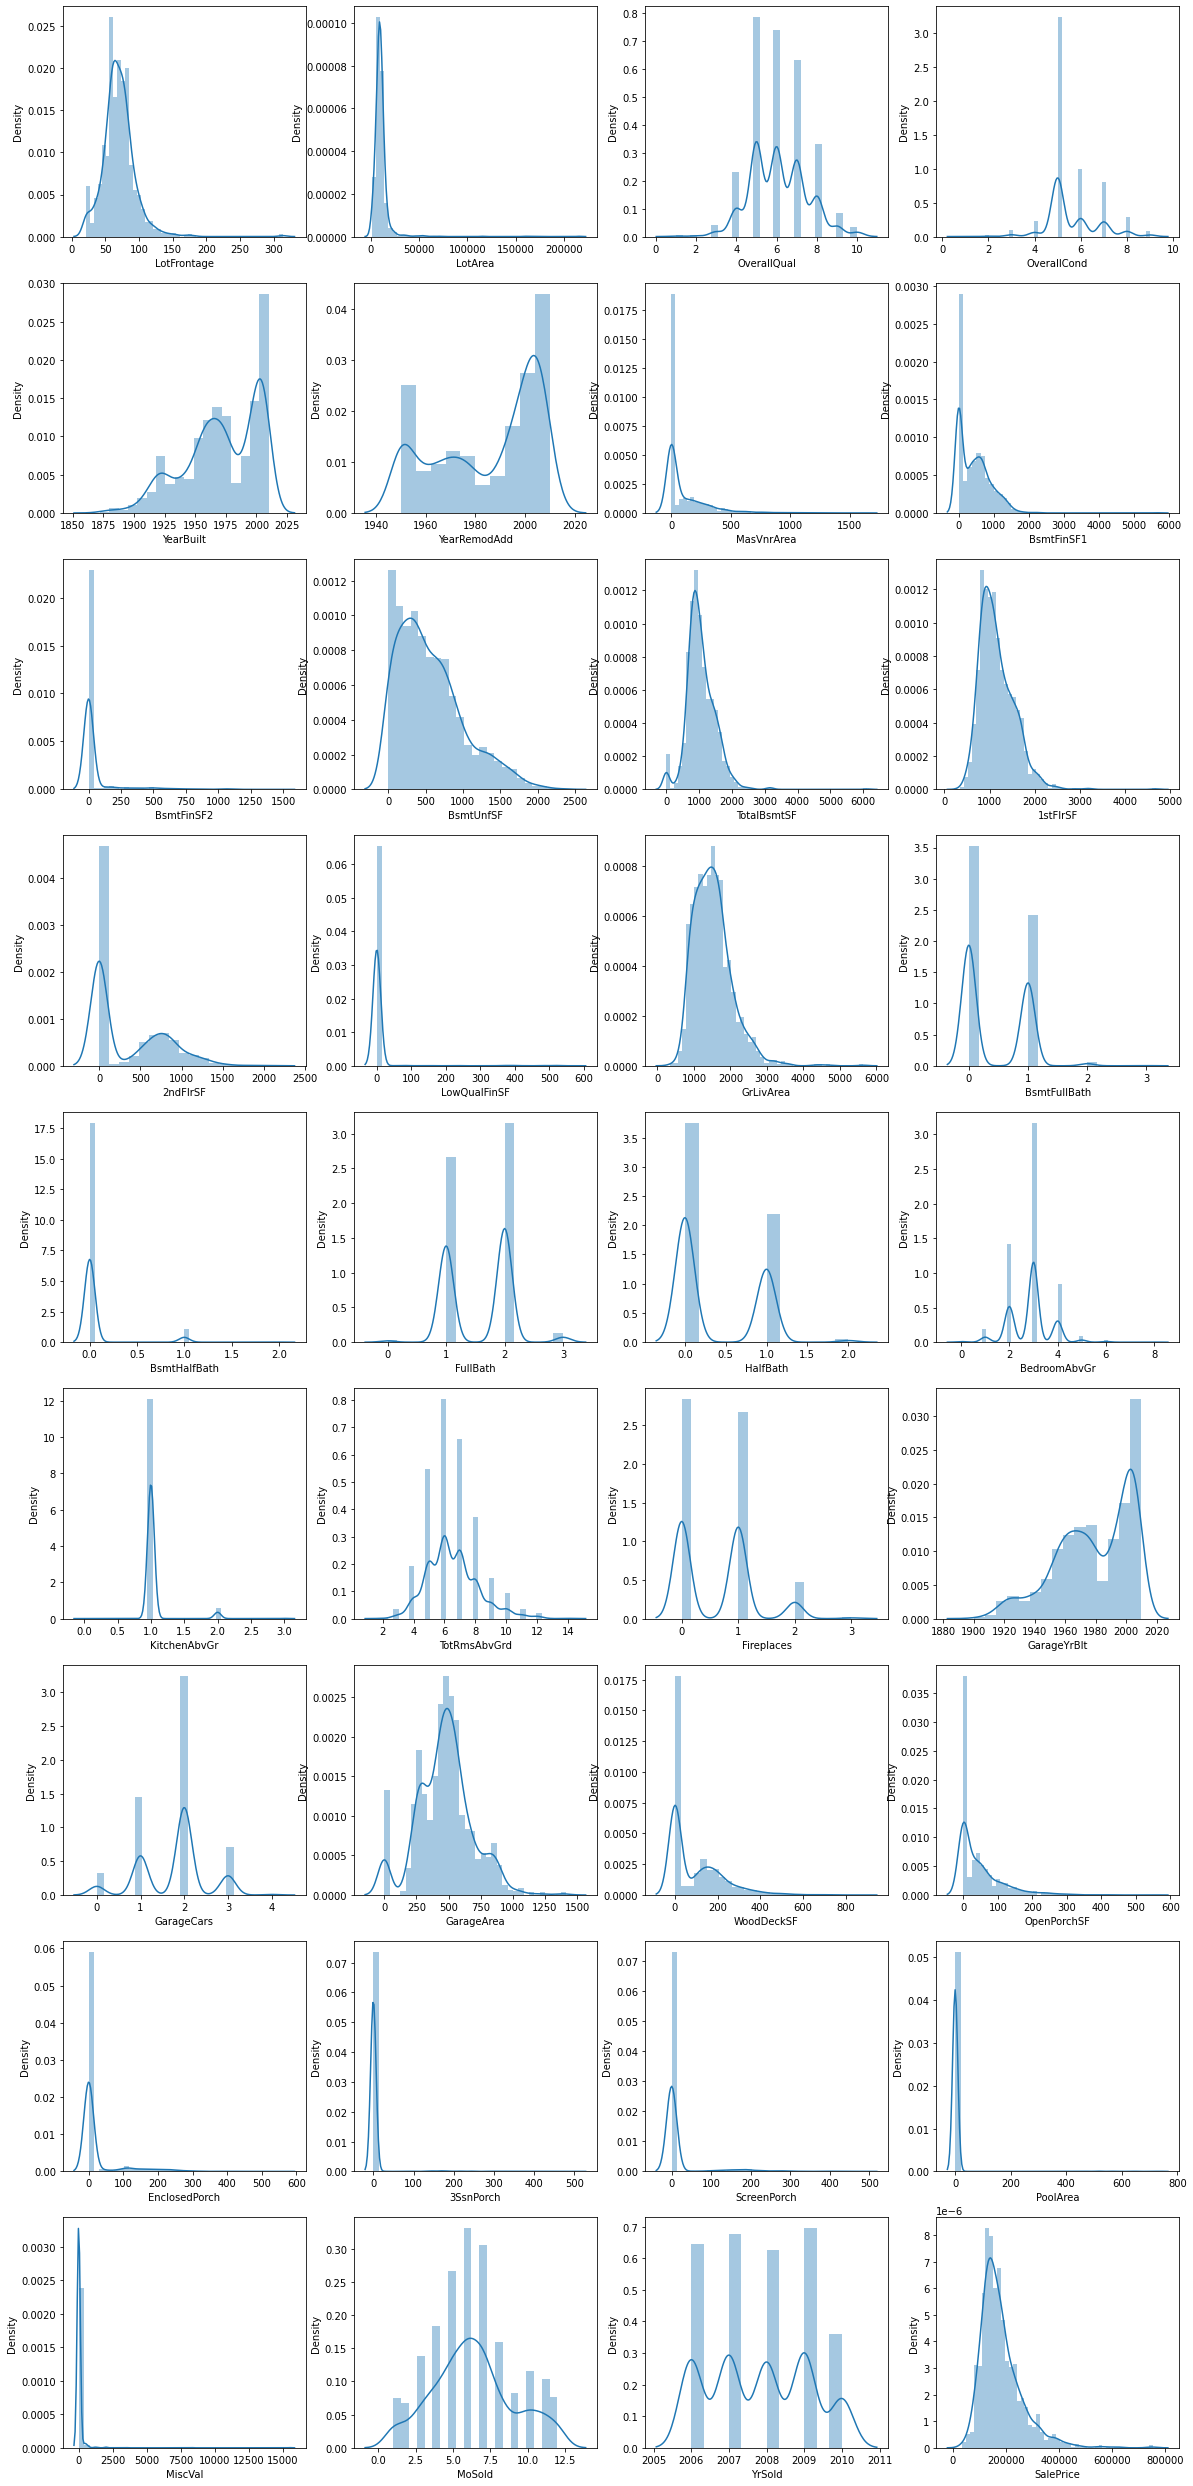

In [10]:
num_var = train_df.select_dtypes(exclude='object')
plt.figure(figsize=(20,50))
i=0
for col in num_var.columns:
    i+=1
    plt.subplot(10,4,i)
    sns.distplot(train_df[col])
plt.show()

Dropping numerical columns which have more than 80% class imbalance

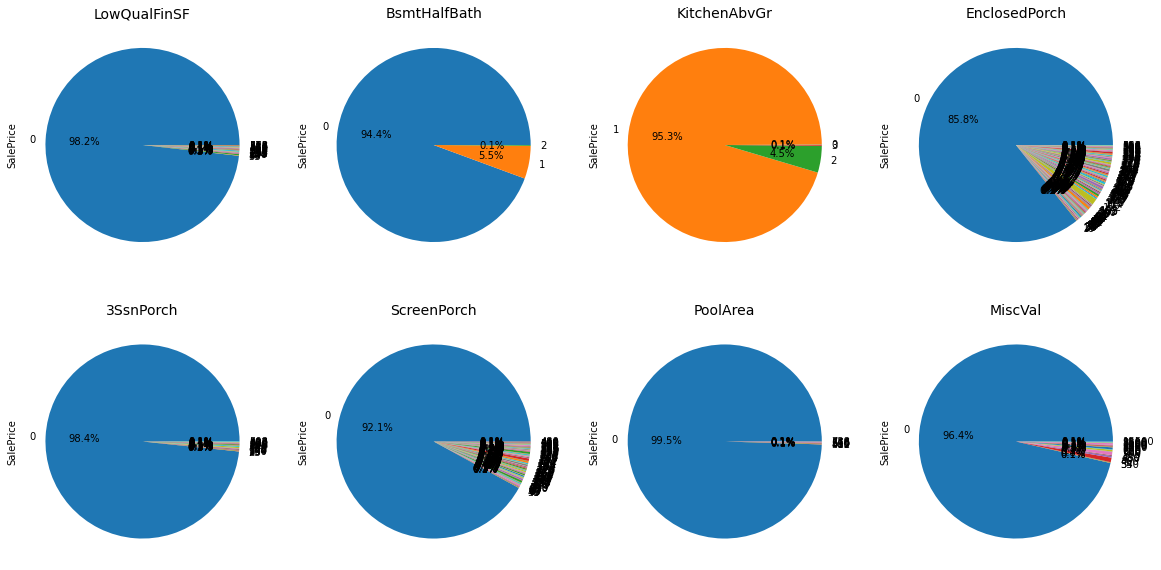

In [11]:
column = ['LowQualFinSF','BsmtHalfBath','KitchenAbvGr','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal']
plt.figure(figsize=(20,10))
i=0
for col in column:
    i+=1
    plt.subplot(2,4,i)
    data = train_df.groupby(col)['SalePrice'].count()/len(train_df[col])
    plt.title(col, fontsize=14)
    data.plot.pie(autopct="%.1f%%",subplots=True)
plt.show()

In [12]:
train_df.drop(column, axis=1, inplace=True)

Analysing correlation of different variables with Target variable and dropping them if they have no correlation with Target variable

In [13]:
def chi_square_test(col1, col2):
    contingency_table = pd.crosstab(
    train_df[col1],
    train_df[col2],
    margins = True
    )
    f_obs = np.array(contingency_table.iloc[:contingency_table.shape[0]-1,:contingency_table.shape[1]-1].values)
    return stats.chi2_contingency(f_obs)[:3]

In [14]:
cat_var = train_df.select_dtypes(include='object')
cols = []
for j in cat_var.columns:
    x = chi_square_test('SalePrice', j)
    if x[1]>=0.5:
        cols.append(j)
        print("SalePrice and "+j+": "+str(x))

SalePrice and MSSubClass: (8937.776489938498, 0.9928572389696766, 9268)
SalePrice and HouseStyle: (4596.789414569782, 0.6482615179447816, 4634)
SalePrice and RoofStyle: (2665.6801874818393, 1.0, 3310)
SalePrice and Exterior1st: (8712.732778251357, 0.9999839433628513, 9268)
SalePrice and Exterior2nd: (9785.82598370394, 0.8469189757654344, 9930)
SalePrice and HeatingQC: (2411.0596566165887, 0.9995946871632676, 2648)


With a p-value >= 0.05 , we have failed to reject the null hypothesis. There is no relationship between 'SalePrice' and the other columns.

In [15]:
train_df.drop(cols, axis=1, inplace=True)

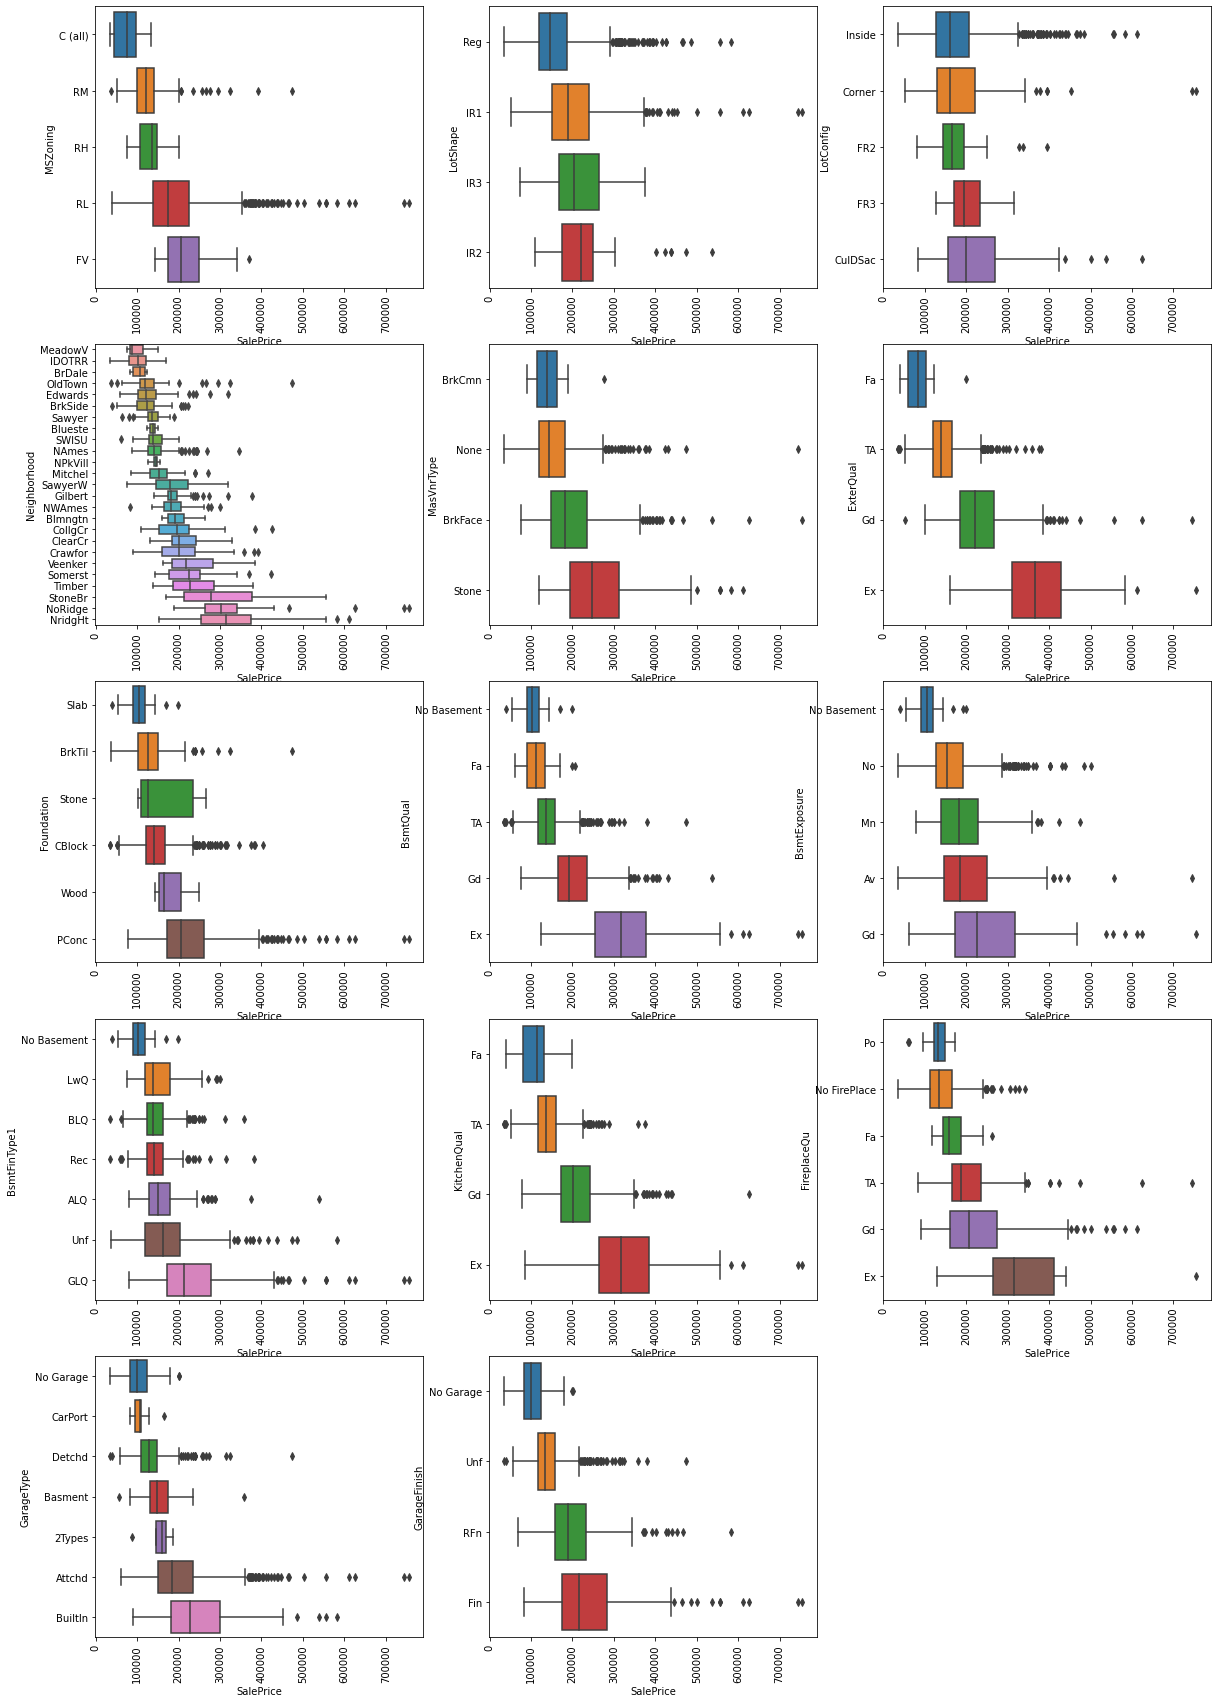

In [16]:
cat_var = train_df.select_dtypes(include='object')
plt.figure(figsize=(20,30))
i=0
plt.tight_layout(h_pad=1.08)
for col in cat_var.columns:
    i+=1
    plt.subplot(5,3,i)
    sorted_nb = train_df.groupby([col])['SalePrice'].median().sort_values()
    sns.boxplot(x='SalePrice', y=col, data=train_df, orient='h', order=list(sorted_nb.index))
    plt.xticks(rotation=90)
plt.show()

Dropping columns which doesn't show relationship with taget variable

In [17]:
col = ['MSZoning','Foundation','BsmtFinType1','GarageType']

In [18]:
train_df.drop(col, axis=1, inplace=True)

Analysing correlation between numweical variables

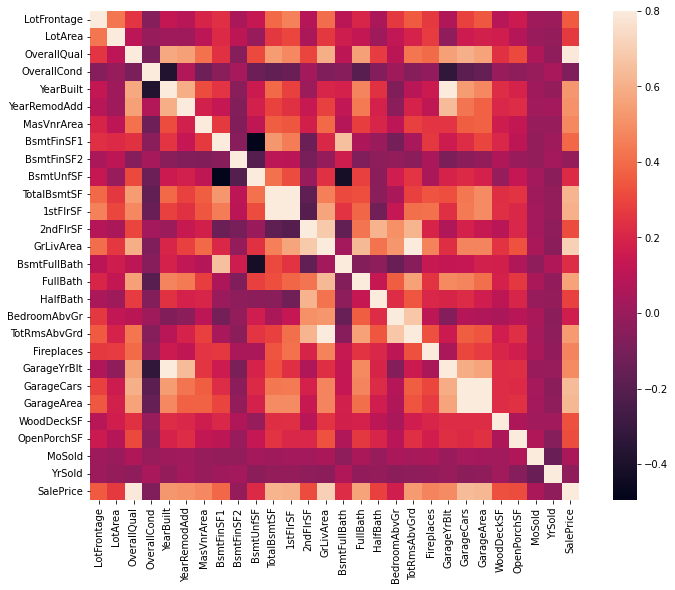

In [19]:
corr = train_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, vmax=.8, square=True);

Analysing top 10 variables with hoghest correlation with Target variable

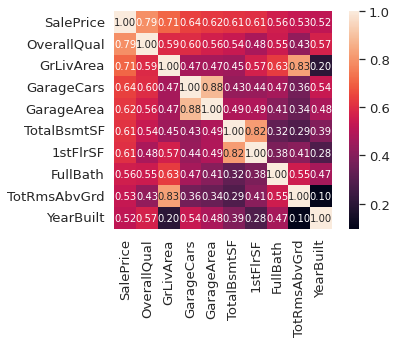

In [20]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.2)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

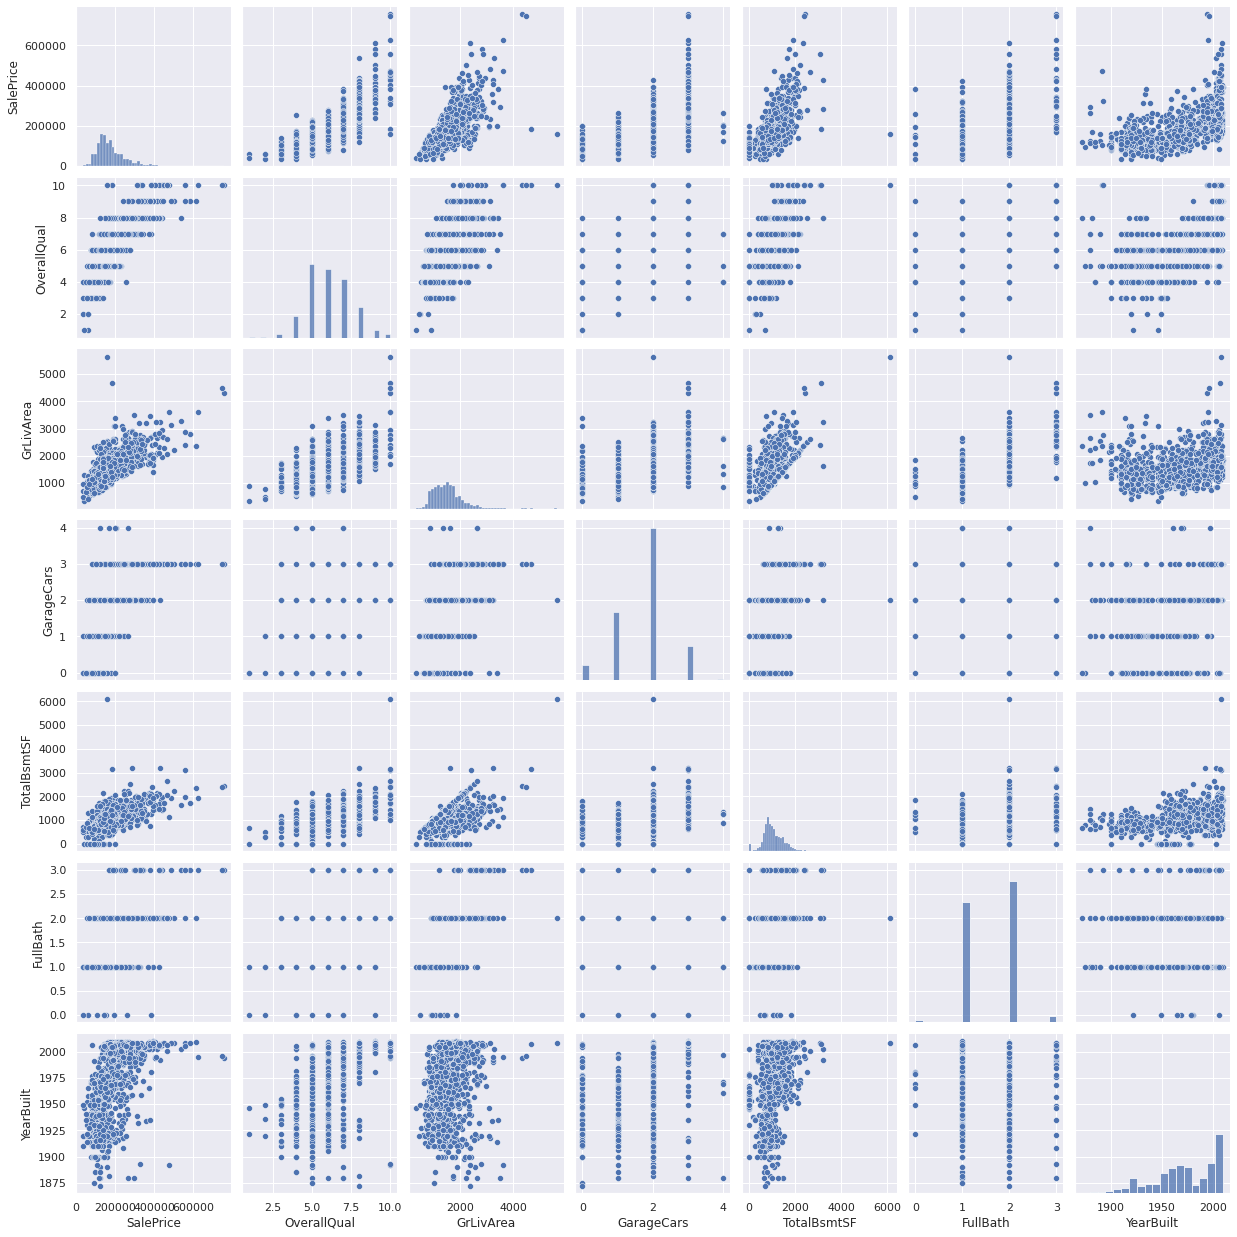

In [21]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train_df[cols], size = 2.5)
plt.show();

Positive skewness can be removed by log transformation

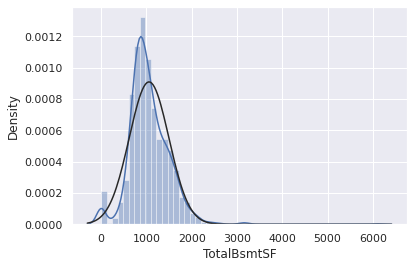

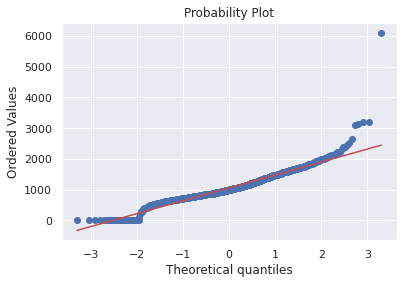

In [22]:
sns.distplot(train_df['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(train_df['TotalBsmtSF'], plot=plt)

There are many instances of 0 value, so we need to be careful while doing log transformation.
Only perform log transformation on non-zero values.

In [23]:
#transform data
train_df.loc[train_df['TotalBsmtSF']>0,'TotalBsmtSF'] = np.log(train_df['TotalBsmtSF'])

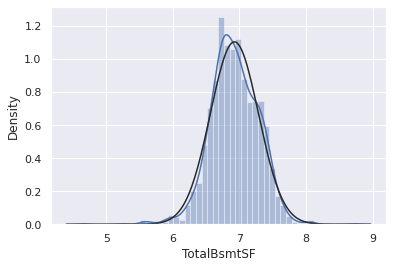

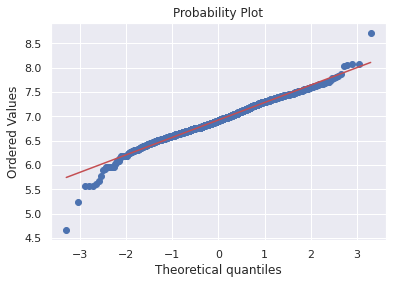

In [24]:
#histogram and normal probability plot
sns.distplot(train_df[train_df['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(train_df[train_df['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

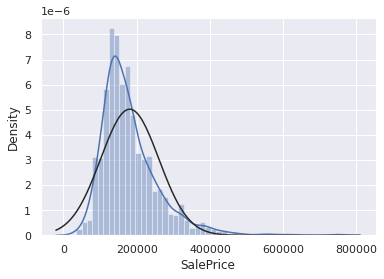

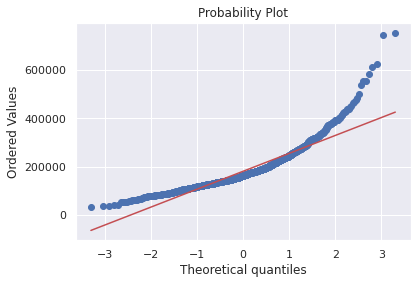

In [25]:
#histogram and normal probability plot
from scipy.stats import norm
sns.distplot(train_df['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)

in case of positive skewness, log transformations usually works well.

In [26]:
#applying log transformation
train_df['SalePrice'] = np.log(train_df['SalePrice'])

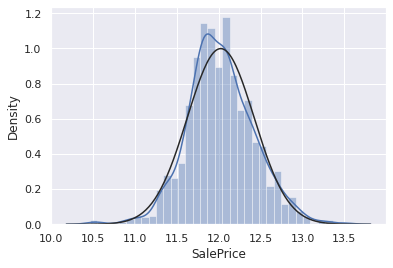

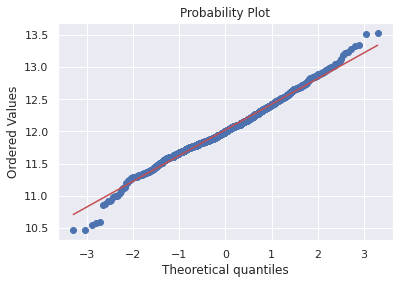

In [27]:
#histogram and normal probability plot

sns.distplot(train_df['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)

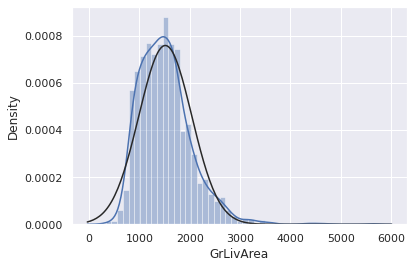

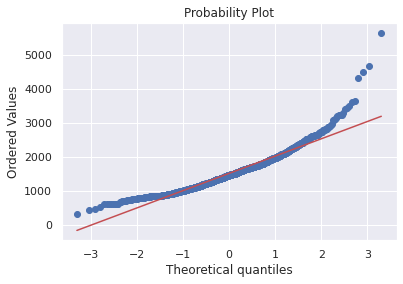

In [28]:
#histogram and normal probability plot
from scipy.stats import norm
sns.distplot(train_df['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(train_df['GrLivArea'], plot=plt)

In [29]:
#applying log transformation
train_df['GrLivArea'] = np.log(train_df['GrLivArea'])

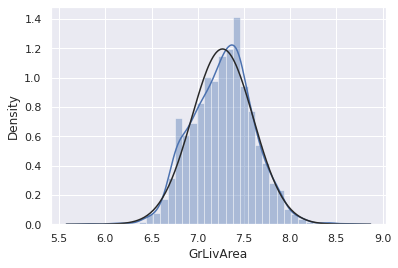

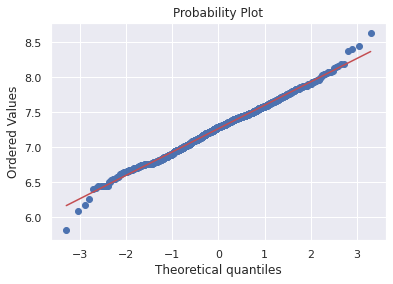

In [30]:
#histogram and normal probability plot
from scipy.stats import norm
sns.distplot(train_df['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(train_df['GrLivArea'], plot=plt)

We are assuming the house in the same neighborhood will be having similar LotFrontage

In [31]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
train_df["LotFrontage"] = train_df.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [32]:
cat_var = train_df.select_dtypes(include='object')
num_var = train_df.select_dtypes(exclude='object')

In [33]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
dummy_df = pd.get_dummies(cat_var, drop_first = True)
df = pd.concat([train_df[cols], dummy_df], axis = 1)

In [34]:
# Create correlation matrix
corr_matrix = df.corr().abs()
x = corr_matrix.unstack().sort_values(ascending=False, kind='quicksort')
print(x[(x.values>.9) & (x.values<1.0)])
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

print(to_drop)
df.drop(to_drop, axis=1, inplace=True)
#corr_matrix.unstack().sort_values(ascending=False, kind='quicksort')

BsmtExposure_No Basement  BsmtQual_No Basement        0.986408
BsmtQual_No Basement      BsmtExposure_No Basement    0.986408
TotalBsmtSF               BsmtQual_No Basement        0.950289
BsmtQual_No Basement      TotalBsmtSF                 0.950289
TotalBsmtSF               BsmtExposure_No Basement    0.937686
BsmtExposure_No Basement  TotalBsmtSF                 0.937686
ExterQual_TA              ExterQual_Gd                0.906121
ExterQual_Gd              ExterQual_TA                0.906121
dtype: float64
['ExterQual_TA', 'BsmtQual_No Basement', 'BsmtExposure_No Basement']


Scaling the data

In [35]:
scaler = MinMaxScaler()
df[cols] = scaler.fit_transform(df[cols])

In [36]:
y = df.pop('SalePrice')
X = df

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

### Linear Regression

In [38]:
# Instantiate
lm = LinearRegression()

# Fit a line
lm.fit(X_train, y_train)

LinearRegression()

In [39]:
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric.append(mse_test_lr**0.5)

0.8797564929905295
0.8606019389082146
2.041938729716291
1.062991205760834
0.001999939989927807
0.0024269205610977945


### Ridge regression

In [40]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 
#https://scikit-learn.org/stable/modules/model_evaluation.html

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    2.1s finished


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [41]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.05}


In [42]:
#Fitting Ridge model for alpha = 10 and printing coefficients which have been penalised
alpha = 0.05
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)

Ridge(alpha=0.05)

In [43]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.8797473123881732
0.8606379011100506
2.042094631918246
1.0627169730778823
0.002000092685522278
0.002426294459081923


### Lasso Regression

In [44]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    2.0s finished


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [45]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.0001}


In [46]:
#Fitting Ridge model for alpha = 100 and printing coefficients which have been penalised

alpha =0.0001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.0001)

In [47]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.8776129027590007
0.8591803630540783
2.0783405282271703
1.0738315475807525
0.0020355930736798925
0.002451670199956056


Top predictor variables

In [48]:
X_train.columns[np.argpartition(lasso.coef_, -5)[-5:]]

Index(['GarageCars', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea', 'OverallQual'], dtype='object')

In [49]:
y=np.argpartition(lasso.coef_, -5)[-5:]

In [50]:
x = np.absolute(lasso.coef_)

Relative feature importance

In [51]:
sum(lasso.coef_[y]/sum(x))

0.45712648625159347

### After removing top 5 predictor variables

In [52]:
col = ['GarageCars', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea', 'OverallQual']

In [53]:
X_train.shape

(1021, 59)

In [54]:
X_train = X_train.drop(col, axis=1)

In [55]:
X_test = X_test.drop(col, axis=1)

In [56]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    2.1s finished


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [57]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.0001}


In [58]:
alpha =0.0001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.0001)

In [59]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.7888868280353418
0.756192677399694
3.585059791660425
1.859172486291434
0.0035113220290503675
0.004244686041761265


In [60]:
X_train.columns[np.argpartition(lasso.coef_, -5)[-5:]]

Index(['BsmtExposure_Gd', 'Neighborhood_Crawfor', 'Neighborhood_NridgHt',
       'Neighborhood_NoRidge', 'FullBath'],
      dtype='object')

In [61]:
# def mltiLabel(col1, col2):
#     mlb = MultiLabelBinarizer()
#     x = mlb.fit_transform(train_df[[col1,col2]].values.tolist())
#     df = pd.DataFrame(x,columns=mlb.classes_)
#     return df

In [62]:
# for i in cat_var.columns:
#     for j in cat_var.columns:
#         x = chi_square_test(i, j)
#         if x[1]>=0.05:
#             print(i+" and "+j+": "+str(x))

In [63]:
# # plt.figure(figsize=(20,50))
# i=0
# for col1 in range(len(cat_var.columns)):
#     for col2 in range(col1+1,len(cat_var.columns)):
#         i+=1
#         plt.subplot(20,4,i)
#         x = dummy_df.loc[[x for x in dummy_df.columns if x.startswith(cat_var.columns[col1])], [x for x in dummy_df.columns if x.startswith(cat_var.columns[col2])]]
#         sns.heatmap(x, annot=True)
# plt.show()